# README for Caltech_UCSD Birds-200-2011

**Introduction to Data:** This dataset consists of photos of 200 bird species where I specifically explored the classification of wrens, sparrows,warblers, and vireos. Associated with the project were the following files:

1.   Images: images of each of the birds
2.   Train/ Test Split: splits for training and testing
3. Bounding boxes: the x, y, width, and height of the boxes surrounding the birds

**Steps** 
1. Imported the data and processed it

> To process the data, I first imported all the files and combined them into a larger dataset that was concated based on bird id. I only kept the four species that were mentioned in the assignment. In the dataframe, there was a column that identifies whether the bird was a training or testing bird. I was then able to create a training and testing data. For both dataframes, I changed all the images to be 224X224X3 and divided the pixel values by 255.0 to ensure their values are between 0 and 1.  

2. Created the 5 layer NN model

> For the model, I had two 32filters followed by two 64 filters. I utilized max-pooling between layers to reduce the amount of parameters and computation cost. Additionally, max-pooling theoretically extracts the sharpest features. I also added some dropout layers to prevent overfitting of the data.

3. Evaluated said model
> I used accuracy and a confusion matrix to evaluate the model to find the TP, FP, TN, FN for each class. This evaluation allowed me to better see which classes were mis-classified and where I needed to focus my energy. 



**Results**
The model achieved 87% accuracy during training, but since the classes were imbalanced, with mostly images of sparrows and warblers, this model needs further image augmentation for the other classes. Hence, although the performance seems high, it is not an accurate depiction of the model success.

**Next Steps**
1. As I simply hard-coded the hyperparameters, I would like to go back and do a grid-search on them. I also would like to explore different variations of architecture. For instance, I think underlying the model with a ResNet framework would likely improve performance.  

2. I need to oversample the vireos and wren classes. 

3. Additionally, I would like to use the bounding-boxes to actually crop the images before processing them. 

4.  I need to remove all the hard coding from my code and transform the blocks of code into actual classes so they're easier to re-use. 



More information on dataset can be found here:

> http://www.vision.caltech.edu/visipedia




1. The first step was to import all the necessary packages

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from functools import reduce
from numpy import asarray
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
np.random.seed(1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


2. Next, I downloaded the data directly from Caltech, extracted the necessary files, and opened them up

The compiled dataset consisted of:


> 1. image_class_labels: bird species labels
> 2. images.txt: file name
> 3. train_test_split.txt: training and testing splits
> 4. bounding_boxes.txt: the bounding boxes




In [ ]:
!wget http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz

--2020-05-16 14:21:54--  http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1150585339 (1.1G) [application/x-tar]
Saving to: ‘CUB_200_2011.tgz’

CUB_200_2011.tgz    100%[===================>]   1.07G  27.0MB/s    in 39s     

2020-05-16 14:22:33 (28.4 MB/s) - ‘CUB_200_2011.tgz’ saved [1150585339/1150585339]



In [ ]:
!tar xvzf CUB_200_2011.tgz

In [ ]:
path = 'CUB_200_2011/'
imageClass =  pd.read_csv(path+"image_class_labels.txt", header=None, sep=" ")
imageClass.columns = ['id', 'class']

imageName = pd.read_csv(path+'images.txt', header=None, sep=" ")
imageName.columns = ['id', 'imageName']

boundingBoxes = pd.read_csv(path+'bounding_boxes.txt',header=None, sep=" ")
boundingBoxes.columns = ['id','x','y','width','height' ]

trainTestSplit = pd.read_csv(path+'train_test_split.txt', header=None, sep=" ")
trainTestSplit.columns = ['id', 'trainTest']

3. After opening up all the different file sources, I needed to create a training and testing set that solely consisting of wrens, warblers, vireos, and sparrows. Hence, I combined all of the txt files together on the bird's id and extracted the training and testing files

In [ ]:
class BirdsData:
  CLASSES = '(Wren|Warbler|Vireo|Sparrow)'
  def __init__(self, initialPath, imageName, imageClass, boundingBoxes, trainTestSplit):
      self.initialPath = initialPath
      self.imageName = imageName
      self.imageClass= imageClass
      self.boundingBoxes = boundingBoxes
      self.trainTestSplit = trainTestSplit

  def createOverallDF(self):
    df = reduce(lambda x,y: pd.merge(x,y, on='id', how='outer'), [self.imageName,self.imageClass, self.boundingBoxes, self.trainTestSplit])
    df2 = df[df['imageName'].str.contains(self.CLASSES, regex=True)]
    df2['class'][df2['imageName'].str.contains('Wren', regex=True)]=0
    df2['class'][df2['imageName'].str.contains('Warbler', regex=True)]=1
    df2['class'][df2['imageName'].str.contains('Vireo', regex=True)]=2
    df2['class'][df2['imageName'].str.contains('Sparrow', regex=True)]=3
    df2.insert(1, 'pathImages',self.initialPath+'images/'+df2['imageName'])
    return df2

  def createTrainTestDFS(self, overallDF):
    testData = overallDF[overallDF['trainTest']==0]
    trainData = overallDF[overallDF['trainTest']==1]
    return trainData, testData
  

In [ ]:
birdData = BirdsData(path, imageName, imageClass, boundingBoxes,trainTestSplit)
overallDF = birdData.createOverallDF()
trainDF, testDF = birdData.createTrainTestDFS(overallDF)

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See

4. From there, I wanted to look at the distribution of classes in the training set. From the count-plot below, one can tell that classes 1 and 3 (warbler and sparrow) are fairly saturated, but wren and vireo are not. Hence, there are a couple options to consider: oversampling, undersampling, and assigning different class weights. As the warbler and sparrow dataset are both around 200 images, it would be to my detriment to downsample. Hence, I would argue oversampling and assigning class weights would work best here.

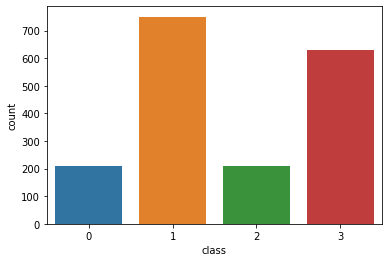

In [ ]:
yTrain = trainDF["class"]
class_weights = class_weight.compute_class_weight('balanced',[0,1,2,3], yTrain)
sns.countplot(yTrain)
xTrain = trainDF.drop(labels = ["class"],axis = 1) 

In [ ]:
inputSize = 224

def loadImage(df):
  l = []
  for i in df.index:
    img = Image.open(df['pathImages'][i])
    imResize = img.resize((inputSize,inputSize), Image.ANTIALIAS)
    pixels = asarray(imResize).astype('float32')
    pixels= pixels/255.0
    l.append(pixels)
  l = np.asarray(l)
  return l

In [ ]:
X_train = loadImage(trainDF)

In [ ]:
X_train.shape

(1798, 224, 224, 3)

In [ ]:
yTrain = to_categorical(yTrain, num_classes = 4)

In [ ]:
yTrain.shape

(1798, 4)

5. I then split my training data into training and a validation set. 80% of the data would be used for training and 20% for validation.

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, yTrain, test_size = 0.2, random_state=1)

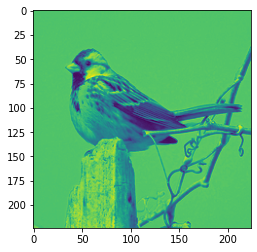

In [ ]:
plt.imshow(X_train[0][:,:,0])

5. For the model, I had two 32filters followed by two 64 filters. I utilized max-pooling between layers to reduce the amount of parameters and computation cost. Additionally, max-pooling theoretically extracts the sharpest features. I also added some dropout layers to prevent overfitting of the data.

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (inputSize,inputSize,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))

6. I then chose the RMSprop optimizer with default values. Ideally, I would have done a grid search to find the best parameters for the optimizer, but I did run out of time.

In [ ]:
from tensorflow import keras

optimizer = keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

7. I augmented the images by rotating them, altering the zoom and flipping them. This prevents the model from overfitting the data.

In [ ]:
datagen = ImageDataGenerator(rotation_range = 30, zoom_range = 0.15, horizontal_flip= True, fill_mode= 'nearest')
it = datagen.flow(X_train, Y_train, batch_size = 32)

8. Finally, I actually fitted the data and visualized it in the confusion matrix below. Class 0 and 2 did not do very well. I need to take some time to over-sample the two classes so they do not automatically default to classes 1 and 3. Overall, this model needs  lot of tuning.

In [ ]:
model.fit(x= X_train, y = Y_train, epochs=10, validation_data = (X_val,Y_val), class_weight= class_weights, batch_size=64,)

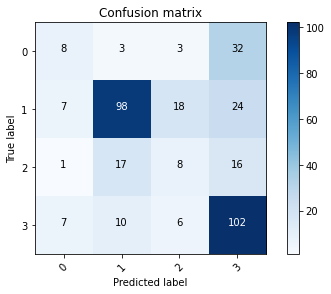

In [ ]:
def confusionMatrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title('Birds Classification')
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

yPredicted = model.predict(X_val) 
YPredictedClasses = np.argmax(yPredicted,axis = 1) 
Y_true = np.argmax(Y_val,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, YPredictedClasses) 
confusionMatrix(confusion_mtx, classes = range(4))

In [ ]:
testData = loadImage(testDF)

In [ ]:
results = model.predict(testData)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Class")

11      1
56      1
65      1
84      1
91      1
       ..
1712    1
1728    1
1749    1
1754    1
1757    1
Name: Class, Length: 648, dtype: int64

Reinitialized existing Git repository in /content/.git/
fatal: pathspec 'README.md' did not match any files
On branch master

Initial commit

Untracked files:
	.config/
	sample_data/

nothing added to commit but untracked files present
fatal: remote origin already exists.
error: src refspec master does not match any.
error: failed to push some refs to 'https://github.com/akats16/birdClassification.git'
